In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
#Building the dataset
block_size=3

def build_dataset(words):
  X,Y=[],[]
  for w in words:
    context= [0]*block_size
    for ch in w+'.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:]+[ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])   #80%
Xdev,Ydev=build_dataset(words[n1:n2])   #10%
Xte,Yte=build_dataset(words[n2:])   #10%


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [53]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)   #Kaiming init
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


tensor(0.0191) tensor(1.0066)
tensor(-0.0007) tensor(1.0216)


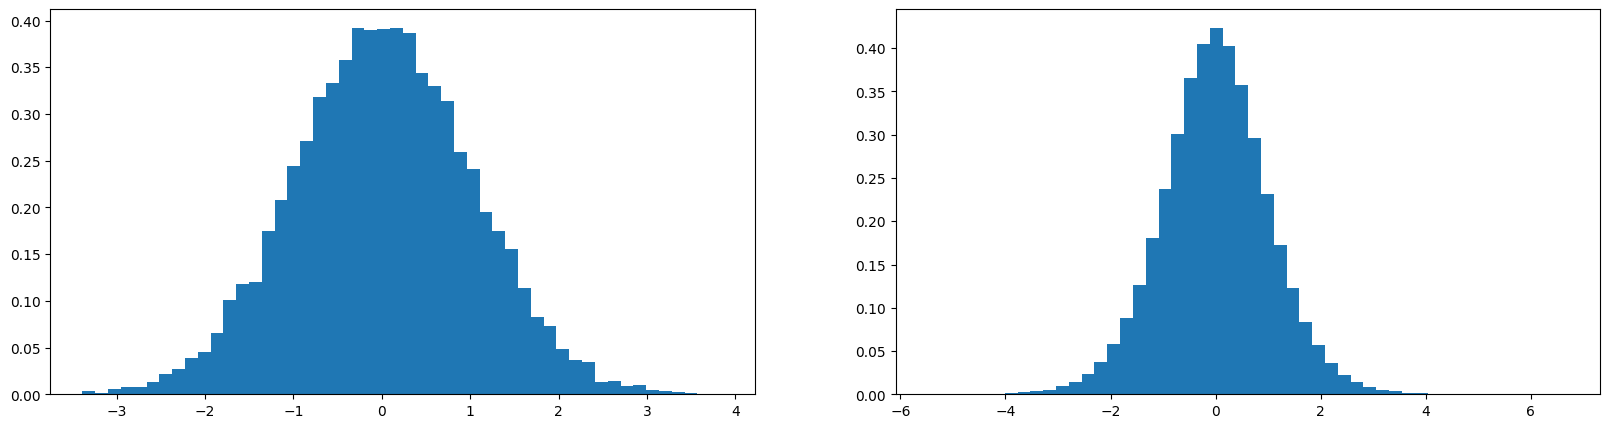

In [52]:
x= torch.randn(1000,10)
w= torch.randn(10,200) / 10**0.5    #Square rooting the fan_in
y= x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [54]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h=torch.tanh(hpreact) #hidden layer
  logits=h @ W2 + b2  #output layer
  loss=F.cross_entropy(logits,Yb) #loss function


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2963
  10000/ 200000: 1.6929
  20000/ 200000: 1.8320
  30000/ 200000: 2.3207
  40000/ 200000: 2.4915
  50000/ 200000: 1.7569
  60000/ 200000: 2.4385
  70000/ 200000: 2.1219
  80000/ 200000: 1.6795
  90000/ 200000: 2.1480
 100000/ 200000: 2.1768
 110000/ 200000: 2.0357
 120000/ 200000: 1.7839
 130000/ 200000: 1.7549
 140000/ 200000: 2.1074
 150000/ 200000: 2.1052
 160000/ 200000: 1.7375
 170000/ 200000: 2.0859
 180000/ 200000: 2.5050
 190000/ 200000: 1.7592


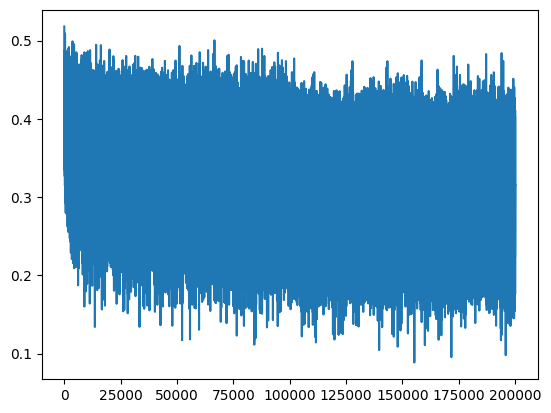

In [44]:
plt.plot(lossi)

In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h=torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.035102605819702
val 2.1148674488067627


In [56]:
g= torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
  out=[]
  context= [0] * block_size
  while True:
    emb=C[torch.tensor([context])]
    h=torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits=h @ W2 + b2
    probs=F.softmax(logits,dim=1)
    #sample from the distribution

    ix=torch.multinomial(probs,num_samples=1,generator=g).item()
    context=context[1:]+[ix]
    out.append(ix)
    if ix==0:
      break
  print(''.join(itos[i] for i in out))


montaymyazharel.
ndhryah.
renyas.
emdrie.
cadelynnelin.
shi.
jenne.
elissopharleigh.
malker.
noshubergiaghansh.
jaireelynn.
novana.
ubukghda.
jamell.
eli.
kayshvonny.
mahia.
salynn.
unazarilee.
ren.
